# Cargar ResNet50 de base

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

imagen_alto = 128
imagen_ancho = 128
canales_de_color = 3

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(imagen_alto, imagen_ancho, canales_de_color))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)


In [3]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Importación de datos

In [4]:
import os
import cv2
import numpy as np
import pathlib
import matplotlib.pyplot as plt

data_dir = pathlib.Path('assets')

# Lista para almacenar las imágenes y etiquetas
imagenes = []
etiquetas = []

# Clases disponibles
clases = ['class_A', 'class_B', 'class_C',]

# Recorrer las carpetas de las clases
for plate in os.listdir(data_dir):
    for clase in clases:
        for file in os.listdir(data_dir / plate / 'resized' / clase):
            # Leer la imagen
            imagen = cv2.imread(str(data_dir / plate / 'resized' / clase / file), cv2.IMREAD_COLOR)
            
            # Normalizar la imagen
            imagen = imagen / 255.0
            # Agregar la imagen a la lista
            imagenes.append(imagen)
            # Agregar la etiqueta a la lista en el formato 0 o 1
            etiquetas.append(0 if clase == 'class_B' else 1)

# Convertir las listas de imágenes y etiquetas a arrays numpy
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

print(imagenes.shape)
print(etiquetas.shape)


(17217, 128, 128, 3)
(17217,)


In [ ]:
# # Submuestreo de la clase mayoritaria
# 
# # Contar el número de muestras de cada clase
# clase_0 = np.sum(etiquetas == 0)
# clase_1 = np.sum(etiquetas == 1)
# 
# # Determinar la clase mayoritaria y la clase minoritaria
# clase_mayoritaria = 0 if clase_0 > clase_1 else 1
# clase_minoritaria = 1 if clase_mayoritaria == 0 else 0
# 
# # Calcular la diferencia entre el número de muestras de la clase mayoritaria y la clase minoritaria
# diferencia = clase_0 - clase_1 if clase_0 > clase_1 else clase_1 - clase_0
# 
# # Encontrar los índices de las muestras de la clase mayoritaria
# indices = np.where(etiquetas == clase_mayoritaria)[0]
# 
# # Seleccionar aleatoriamente las muestras de la clase mayoritaria a eliminar
# indices = np.random.choice(indices, diferencia, replace=False)
# 
# # Eliminar las muestras de la clase mayoritaria
# imagenes = np.delete(imagenes, indices, axis=0)
# etiquetas = np.delete(etiquetas, indices, axis=0)
# 
# # Contar el número de muestras de cada clase después del submuestreo
# clase_0 = np.sum(etiquetas == 0)
# clase_1 = np.sum(etiquetas == 1)
# 
# print(clase_0, clase_1)
# 
# # etiquetas = tf.keras.utils.to_categorical(etiquetas, num_classes=2)
# 
# print(imagenes.shape)
# print(etiquetas.shape)
# 

In [5]:
# Oversampling de la clase minoritaria

# Contar el número de muestras de cada clase
clase_0 = np.sum(etiquetas == 0)
clase_1 = np.sum(etiquetas == 1)

# Determinar la clase mayoritaria y la clase minoritaria
clase_mayoritaria = 0 if clase_0 > clase_1 else 1
clase_minoritaria = 1 if clase_mayoritaria == 0 else 0

# Calcular la diferencia entre el número de muestras de la clase mayoritaria y la clase minoritaria
diferencia = clase_0 - clase_1 if clase_0 > clase_1 else clase_1 - clase_0

# Encontrar los índices de las muestras de la clase minoritaria
indices = np.where(etiquetas == clase_minoritaria)[0]

# Seleccionar aleatoriamente las muestras de la clase minoritaria a duplicar
indices = np.random.choice(indices, diferencia, replace=True)

# Duplicar las muestras de la clase minoritaria
imagenes = np.concatenate((imagenes, imagenes[indices]), axis=0)
etiquetas = np.concatenate((etiquetas, etiquetas[indices]), axis=0)

# Contar el número de muestras de cada clase después del sobremuestreo
clase_0 = np.sum(etiquetas == 0)
clase_1 = np.sum(etiquetas == 1)

print(clase_0, clase_1)




16021 16021


# Alistamiento de los datos

In [6]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y validación
imagenes_entrenamiento, imagenes_validacion, etiquetas_entrenamiento, etiquetas_validacion = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)

# Convertir las listas de imágenes y etiquetas de entrenamiento a arrays numpy
imagenes_entrenamiento = np.array(imagenes_entrenamiento)
etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)

# Convertir las listas de imágenes y etiquetas de validación a arrays numpy
imagenes_validacion = np.array(imagenes_validacion)
etiquetas_validacion = np.array(etiquetas_validacion)

# Entrenar el modelo

In [7]:
num_epochs = 12
batch_size = 32

# Directorio donde se guardarán los registros para TensorBoard
# directorio_logs = "logs/"

# Callback de TensorBoard
# tensorboard_callback = TensorBoard(log_dir=directorio_logs, histogram_freq=1)

# Entrenar el modelo con el callback de TensorBoard
model.fit(
    imagenes_entrenamiento, etiquetas_entrenamiento,
    epochs=num_epochs,
    batch_size=batch_size,
    )


Epoch 1/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 556s 682ms/step - accuracy: 0.6160 - loss: 0.6588
Epoch 2/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 556s 693ms/step - accuracy: 0.6901 - loss: 0.5894
Epoch 3/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 590s 736ms/step - accuracy: 0.6970 - loss: 0.5807
Epoch 4/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 549s 684ms/step - accuracy: 0.6985 - loss: 0.5730
Epoch 5/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 540s 673ms/step - accuracy: 0.7005 - loss: 0.5658
Epoch 6/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 541s 674ms/step - accuracy: 0.7082 - loss: 0.5587
Epoch 7/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 1511s 2s/step - accuracy: 0.7149 - loss: 0.5496
Epoch 8/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 543s 676ms/step - accuracy: 0.7152 - loss: 0.5503
Epoch 9/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 4043s 5s/step - accuracy: 0.7180 - loss: 0.5414
Epoch 10/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 555s 693ms/step - accuracy: 0.7198 - loss: 0.5429
Epoch 11/12
802/802 ━━━━━━━━━━━━━━━━━━━━ 5688s 7s/step - accuracy: 0.7271 - loss: 0.5402
Epoch 12/12
80

# Evaluar el modelo

In [8]:
test_loss, test_acc = model.evaluate(imagenes_validacion, etiquetas_validacion)
print('Precisión en datos de prueba:', test_acc)

201/201 ━━━━━━━━━━━━━━━━━━━━ 145s 711ms/step - accuracy: 0.7345 - loss: 0.5438
Precisión en datos de prueba: 0.7381806969642639


# Guardado del entrenamiento

In [9]:
model.save_weights('pesos_modelo_cnn.weights.h5')
model.save(filepath='modelo_cnn.keras')

In [38]:
# Make a sound when done

import winsound
frequency = 880  # Set Frequency To 2500 Hertz

duration = 700  # Set Duration To 1000 ms == 1 second

winsound.Beep(frequency, duration)


201/201 ━━━━━━━━━━━━━━━━━━━━ 139s 675ms/step


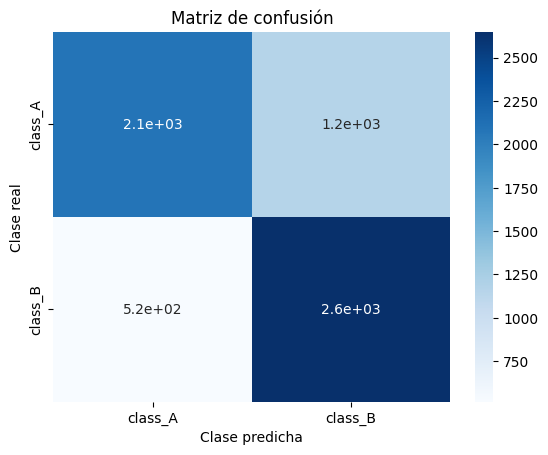

In [10]:
# Mostrar la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn
import pandas


clases = ['class_A', 'class_B']
# Obtener las predicciones del modelo
predicciones = model.predict(imagenes_validacion)

# Convertir las predicciones a etiquetas
predicciones = np.where(predicciones > 0.5, 1, 0)

# Calcular la matriz de confusión
cm = confusion_matrix(etiquetas_validacion, predicciones)

# Crear un DataFrame de pandas con la matriz de confusión
df = pandas.DataFrame(cm, index=clases, columns=clases)


# Mostrar la matriz de confusión
seaborn.heatmap(df, annot=True, cmap='Blues')
plt.xlabel('Clase predicha')
plt.ylabel('Clase real')
plt.title('Matriz de confusión')
plt.show()


# Cargar el modelo y los pesos

In [9]:
# loaded_model = models.load_model('modelo_cnn.keras')

# loaded_model.load_weights('pesos_modelo_cnn.weights.h5')

# Cargar una imagen de prueba

In [ ]:
import os

OPENSLIDE_PATH = r'C:\Users\achav\Documents\Osteoartritis\openslide-win64\bin'

if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
        print('Using OpenSlide from', openslide.__file__)
else:
    import openslide

plate_name = "Ms-13-22-1_001"
plate_path = plate_name + ".svs"
path = f"assets/{plate_path}"

# Check if file exists
if not os.path.isfile(path):
    print(f"File {path} not found")

slide = openslide.OpenSlide(path)

# Get a thumbnail of the whole slide
thumbnail = slide.get_thumbnail((slide.dimensions[0] // 64, slide.dimensions[1] // 64))

# Convert the thumbnail to a numpy array
thumbnail = np.array(thumbnail)

# Display the thumbnail
plt.imshow(thumbnail)

plate_name = "Ms-13-22-1_001"
plate_path = plate_name + ".svs"
path = f"assets/{plate_path}"

# Check if file exists
if not os.path.isfile(path):
    print(f"File {path} not found")

slide = openslide.OpenSlide(path)

# Get a thumbnail of the whole slide
thumbnail = slide.get_thumbnail((slide.dimensions[0] // 64, slide.dimensions[1] // 64))

# Convert the thumbnail to a numpy array
thumbnail = np.array(thumbnail)

# Display the thumbnail
plt.imshow(thumbnail)

In [ ]:
from collections import defaultdict

from time import sleep

class_colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)}
level = 0

# Get the dimensions of the slide
width, height = slide.level_dimensions[level]

print(slide.level_dimensions)
print(slide.level_downsamples)
print(width, height)

# Create a count dict to store the number of tiles for each class
count = defaultdict(int)

original = np.array(slide.read_region((0, 0), level, (width, height)).convert("RGB"))

# Convert the image to a numpy array
# results = np.zeros((width, height, 3), dtype=np.uint8)

# print(results.shape)
for i in range(0, 1023, 1024):
    print(f"i: {i} / {height}")
    for j in range(0, 1023, 1024):
        print(f"j: {j} / {width}")
        try:
            
            image = slide.read_region((i, j), level, (256, 256)).convert("RGB")
            # Show thumbnail
            image = image.resize((128, 128))  # Ajustar al tamaño esperado por el modelo
            image = np.array(image)
            # plt.imshow(image)

            # Asegurarse de que la imagen tiene la forma correcta (128, 128, 3)
            image = np.expand_dims(image, axis=0)  # Añadir una dimensión para el batch
            # Hacer predicción con el modelo
            prediction = model.predict(image, verbose=0)
            print(prediction)
            # Obtener la clase con la mayor probabilidad
            prediction = np.argmax(prediction)
            # print(f"Prediction: {prediction}")
            
            # Pintar la región de la imagen original con el color de la clase predicha
            # cv2.rectangle(original, (i, j), (i + 256, j + 256), class_colors[prediction], 100)
            # cv2.rectangle(results, (i, j), (i + 256, j + 256), class_colors[prediction], -1)
            
            # Ajustar el tamaño del bloque a 4x4 en la matriz de resultados
            count[prediction] += 1

        except Exception as e:
            winsound.Beep(880, 1000)
            print(e)


        # Compare original image with the predicted image
        #plt.figure(figsize=(10, 10))
        #plt.subplot(1, 2, 1)
        #thumbnail = cv2.resize(original, (width // 64, height// 64))
        #plt.imshow(thumbnail)
        #plt.title("Original Image")
        #plt.axis("off")

        #plt.subplot(1, 2, 2)

        ## Resize the results to the same size as the original image
        #resultados = cv2.resize(results, (thumbnail.shape[1], thumbnail.shape[0]))

        #plt.imshow(resultados)
        #plt.title("Predicted Image")
        #plt.axis("off")

        #plt.show()
        

# Reduce in a factor of 4
# cv2.imwrite("original.png", cv2.resize(thumbnail, (width, height), interpolation=cv2.INTER_NEAREST))
# cv2.imwrite("results.png", cv2.resize(results, (width, height), interpolation=cv2.INTER_NEAREST))

winsound.Beep(880, 1000)
print(count)

In [ ]:
# Compare original image with the predicted image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(thumbnail)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)

# Resize the results to the same size as the original image
results = cv2.resize(results, (thumbnail.shape[1], thumbnail.shape[0]))

plt.imshow(results)
plt.title("Predicted Image")
plt.axis("off")

plt.show()